In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
np.set_printoptions(threshold=sys.maxsize)

In [184]:
################什么是XGBoost?

In [3]:
#############这和我们上次做的LightGBM是一个类似的算法
############LightGBM似乎是他的一个升级版
###########XG将K个树的结果凑在一起作为预测值
############还是之前的那一组数据
###########来看看XGBOOST:https://www.jianshu.com/p/a62f4dce3ce8
##########和之前的LGBM有一个显著的不同就是最优分割点的选择不同：
##########XGB有两种选取分割点的方法：一种是贪心分割
#########贪心分割就是枚举每个潜在的分割点选最好的，计算消耗大，会首先对特征进行排序
########第二种就是根据特征分布的N个百分位数提出N个最佳分割点，然后把数据放在桶里，然会计算最佳分割点
########有两种分割方式：1.局部近似 2.全局近似
########局部近似是我们在每个节点分裂的时候再考虑其分位点并划分样本
########全局近似是我们在一棵树还没有产生的时候我们就考虑分位点并划分样本

In [185]:
#############什么是随机森林

In [186]:
##随机森林指的是利用多棵树对样本进行训练并预测的一种分类器。
##首先是又放回的对数据抽样
##得到了众多数目不同的数据,当然训练出了诸多不同的树
##之后每次预测都是不同树之间投票
##分裂点不一定涵盖所有属性啊，和lgb一样有限制的

In [4]:
path="./XGBoost.data/"

In [5]:
train_path=path+"train.csv"
test_path=path+"test.csv"

In [6]:
df_train=pd.read_csv(train_path)

In [7]:
#####################EDA分析
######################Kaggle提供的地区跨度

In [8]:
df_test=pd.read_csv(test_path)

In [9]:
places=df_train["Country/Region"].unique()

In [10]:
places.shape

(163,)

In [11]:
########################Kaggle提供的时间跨度
########################是差不多一个月的跨度
########################需要转化时间序列的属性

In [12]:
df_train["Date"]=pd.to_datetime(df_train["Date"])   

In [13]:
print(len(df_train["Date"].unique()))

63


In [14]:
#######################每天世界的已确诊人数总和

In [15]:
train_cases_conf = df_train.groupby(['Date'])['ConfirmedCases'].sum()
train_cases_conf

Date
2020-01-22       539
2020-01-23       627
2020-01-24       901
2020-01-25      1347
2020-01-26      1959
               ...  
2020-03-20    268110
2020-03-21    300255
2020-03-22    331467
2020-03-23    373583
2020-03-24    391426
Name: ConfirmedCases, Length: 63, dtype: int64

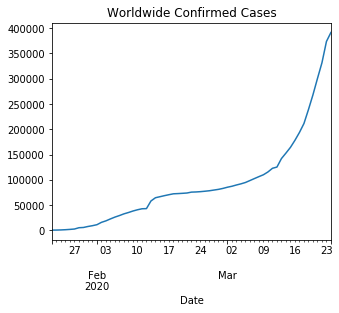

In [16]:
train_cases_conf.plot(figsize = (5,4), title = 'Worldwide Confirmed Cases')
#####################上升期-稳定期-爆发期

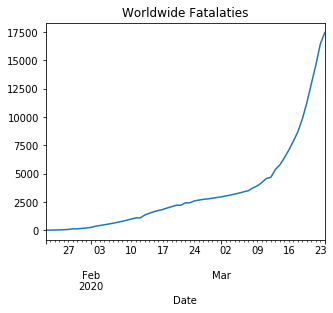

In [17]:
train_fatal = df_train.groupby(['Date'])['Fatalities'].sum()
train_fatal.plot(figsize = (5,4), title = 'Worldwide Fatalaties')
####################死亡人数在确诊人数进入爆发期后同样进入了爆发期

In [18]:
#########################观察不同地区的实际情况
#########################对比我们国家和美帝
#########################完全不同的局势啊，我们前期高爆后期稳定,美帝前期平稳后期爆发

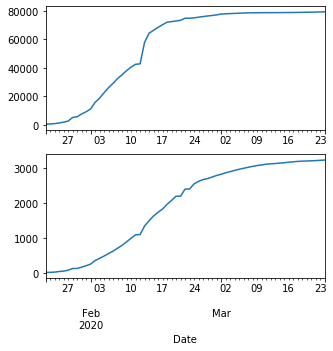

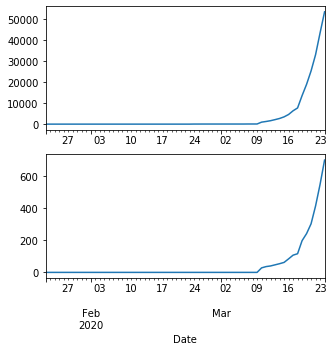

In [19]:
def country_stats(country, df):
    country_filt = (df['Country/Region'] == country)
    df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
    df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    fig, axes = plt.subplots(nrows = 2, ncols= 1, figsize=(5,5))
    df_cases.plot(ax = axes[0])
    df_fatal.plot(ax = axes[1])
country_stats('China', df_train)
country_stats('US', df_train)

In [20]:
##################这里比较的是不同国家每个地区疫情最严重城市的确诊人数
#################为什么意大利比我们确诊人数多？
################因为意大利本身就一个地区,单独疫情最严重的湖北地区确诊人数比不上整个意大利的确诊人数

<BarContainer object of 5 artists>

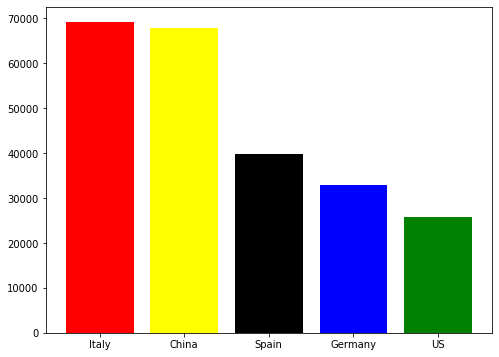

In [21]:
train_case_country = df_train.groupby(['Country/Region'], as_index=False)['ConfirmedCases'].max()
###########################
train_case_country.sort_values('ConfirmedCases', ascending=False, inplace = True)
train_case_country
plt.figure(figsize=(8,6))
plt.bar(train_case_country['Country/Region'][:5], train_case_country['ConfirmedCases'][:5], color = ['red', 'yellow','black','blue','green'])

In [22]:
##################这里比较的才是全国确诊人数
#################我们国家第一名

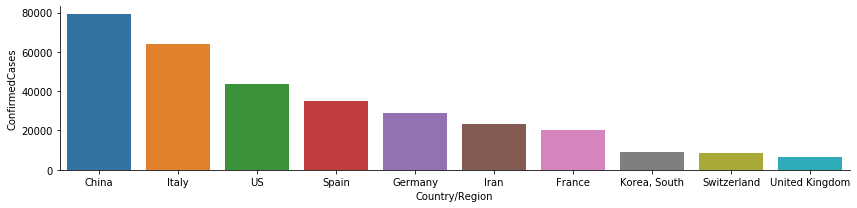

In [23]:
def case_day_country (Date, df):
    df = df.groupby(['Country/Region', 'Date'], as_index = False)['ConfirmedCases'].sum()
    date_filter = (df['Date'] == Date)
    df = df.loc[date_filter]
    df.sort_values('ConfirmedCases', ascending = False, inplace = True)
    sns.catplot(x = 'Country/Region', y = 'ConfirmedCases' , data = df.head(10), height=3,aspect=4, kind = 'bar')
case_day_country('2020-03-23', df_train)

In [24]:
################在这里停下来
################数据处理部分

In [25]:
df_train.Date=pd.to_datetime(df_train["Date"])
df_test.Date=pd.to_datetime(df_test["Date"])
##################测试集和训练集有重合,这会导致什么情况？
##################1.这样会夸大模型对于数据的拟合效果
##################2.其实我们拟合的数据更加多了，应该能做出更好的模型了
##################3.但是为了保证衡量模型的公正性：
##################我们应该这么做：
##################1.手动剪裁训练集
##################2.手动剪裁测试集,但是测试集合是不可能剪辑的，这会导致无法提交
##############所以只能手动剪辑训练集合

In [26]:
print(df_train['Date'].max())
print(df_test['Date'].min())        

2020-03-24 00:00:00
2020-03-12 00:00:00


In [27]:
date_filter = df_train['Date'] < df_test['Date'].min()
df_train = df_train.loc[date_filter]

In [28]:
train_country_date = df_train.groupby(['Country/Region', 'Date', 'Lat', 'Long'], as_index=False)['ConfirmedCases', 'Fatalities'].sum()

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [29]:
train_country_date.head() 
#############"Province"的缺失值太多了,我们丢弃了，丢弃了缺失值

,Country/Region,Date,Lat,Long,ConfirmedCases,Fatalities
0,Afghanistan,2020-01-22,33.0,65.0,0,0
1,Afghanistan,2020-01-23,33.0,65.0,0,0
2,Afghanistan,2020-01-24,33.0,65.0,0,0
3,Afghanistan,2020-01-25,33.0,65.0,0,0
4,Afghanistan,2020-01-26,33.0,65.0,0,0


In [30]:
################特征工程开始

In [31]:
df_test.drop('Province/State', axis = 1, inplace = True)
df_test.Date = pd.to_datetime(df_test['Date'])

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12212 entries, 0 to 12211
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ForecastId      12212 non-null  int64         
 1   Country/Region  12212 non-null  object        
 2   Lat             12212 non-null  float64       
 3   Long            12212 non-null  float64       
 4   Date            12212 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 477.2+ KB


In [33]:
##################直接处理时间数据很麻烦，都转化为日期排序数据

In [34]:
train_country_date['Month'] = train_country_date['Date'].dt.month
train_country_date['Day'] = train_country_date['Date'].dt.day
train_country_date['Day_Week'] = train_country_date['Date'].dt.dayofweek
train_country_date['quarter'] = train_country_date['Date'].dt.quarter
train_country_date['dayofyear'] = train_country_date['Date'].dt.dayofyear
train_country_date['weekofyear'] = train_country_date['Date'].dt.weekofyear
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['Day_Week'] = df_test['Date'].dt.dayofweek
df_test['quarter'] = df_test['Date'].dt.quarter
df_test['dayofyear'] = df_test['Date'].dt.dayofyear
df_test['weekofyear'] = df_test['Date'].dt.weekofyear

In [35]:
########特征工程是基于原有的特征构造新的特征
########训练集有的特征测试集也要有
########所以不如放在一起做特征,就不需要做两次了

In [51]:
labels = ['Country/Region', 'Lat', 'Long', 'Date', 'Month', 'Day', 'Day_Week','quarter', 'dayofyear', 'weekofyear']
df_train_clean = train_country_date[labels]
df_test_clean = df_test[labels]
data_clean = pd.concat([df_train_clean, df_test_clean], axis = 0)

In [37]:
#######################地区是字符串属性,同样需要转化属性,再编码一次？

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
enc = LabelEncoder()
data_clean['Country'] = enc.fit_transform(data_clean['Country/Region'])
data_clean.head()               ##############为地区编号

,Country/Region,Lat,Long,Date,Month,Day,Day_Week,quarter,dayofyear,weekofyear,Country
0,Afghanistan,33.0,65.0,2020-01-22,1,22,2,1,22,4,0
1,Afghanistan,33.0,65.0,2020-01-23,1,23,3,1,23,4,0
2,Afghanistan,33.0,65.0,2020-01-24,1,24,4,1,24,4,0
3,Afghanistan,33.0,65.0,2020-01-25,1,25,5,1,25,4,0
4,Afghanistan,33.0,65.0,2020-01-26,1,26,6,1,26,4,0


In [54]:
#################原来的国家数据可以丢掉了

In [55]:
data_clean.drop(['Country/Region', 'Date'], axis = 1, inplace=True)

In [50]:
#########################划分训练集和测试集，之前合并了

In [56]:
index_split = df_train.shape[0]
data_train_clean = data_clean[:index_split]
data_test_clean = data_clean[index_split:]

In [58]:
######################查看训练集以及测试集数据

In [59]:
data_train_clean.head()

,Lat,Long,Month,Day,Day_Week,quarter,dayofyear,weekofyear,Country
0,33.0,65.0,1,22,2,1,22,4,0
1,33.0,65.0,1,23,3,1,23,4,0
2,33.0,65.0,1,24,4,1,24,4,0
3,33.0,65.0,1,25,5,1,25,4,0
4,33.0,65.0,1,26,6,1,26,4,0


In [60]:
data_test_clean.head()

,Lat,Long,Month,Day,Day_Week,quarter,dayofyear,weekofyear,Country
0,33.0,65.0,3,12,3,1,72,11,0
1,33.0,65.0,3,13,4,1,73,11,0
2,33.0,65.0,3,14,5,1,74,11,0
3,33.0,65.0,3,15,6,1,75,11,0
4,33.0,65.0,3,16,0,1,76,12,0


In [63]:
########################分离属性变量以及目标变量

In [64]:
x = data_train_clean[['Lat', 'Long', 'Month', 'Day', 'Day_Week','quarter', 'dayofyear', 'weekofyear', 'Country']]
y_case = df_train['ConfirmedCases']
y_fatal = df_train['Fatalities']

In [82]:
###########################73开分离训练数据以及测试数据
##########################注意啊，我们现在在调树的数目阶段
##########################我们是用训练集的一部分调参数

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y_case, test_size = 0.3, random_state = 42)

In [68]:
x_train_fatal, x_test_fatal, y_train_fatal, y_test_fatal = train_test_split(x, y_fatal, test_size = 0.3, random_state = 42)

In [69]:
####################建模

In [70]:
###################首先是随机深林

In [119]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
#############################这个参数是什么意思？
########################森林中树的数目

In [120]:
rf = RandomForestRegressor(n_estimators =100)

In [121]:
rf.fit(x_train, y_train.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [122]:
rf.score(x_train, y_train)

0.9525416992694734

In [123]:
rf.score(x_test, y_test)

0.7638272078895423

In [78]:
##############引入测评函数

In [79]:
from sklearn.metrics import mean_squared_error

In [130]:
y_pred_train = rf.predict(x_train)
print(mean_squared_error(y_train, y_pred_train))

355468.9710330583


In [85]:
###########################参数合适,最后的模型当然要在整个训练集合上学习
###########################稍微有点慢

In [84]:
rf.fit(x, y_case.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
#############回顾我们真正的测试数据,完全没有打标人为的测试数据

In [92]:
data_test_clean.head()

,Lat,Long,Month,Day,Day_Week,quarter,dayofyear,weekofyear,Country
0,33.0,65.0,3,12,3,1,72,11,0
1,33.0,65.0,3,13,4,1,73,11,0
2,33.0,65.0,3,14,5,1,74,11,0
3,33.0,65.0,3,15,6,1,75,11,0
4,33.0,65.0,3,16,0,1,76,12,0


In [93]:
#############用最终模型去预测
rf_pred_case = rf.predict(data_test_clean)

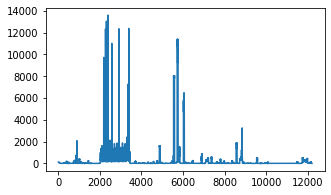

In [100]:
plt.figure(figsize=(5,3))
plt.plot(rf_pred_case)

In [95]:
#####################建模致死率

In [96]:
rf.fit(x, y_fatal.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [97]:
rf_pred_fatal = rf.predict(data_test_clean)

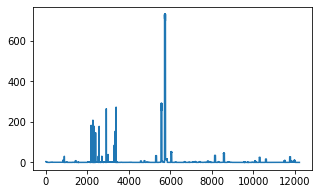

In [101]:
plt.figure(figsize=(5,3))
plt.plot(rf_pred_fatal)

In [106]:
##################XGBOOST来了
##################XGBOOST安装要费点力气：https://blog.csdn.net/lvsehaiyang1993/article/details/80619495

In [115]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [109]:
###########################偷别人的参数

In [148]:
reg = xgb.XGBRegressor(n_estimators=1000,min_child_weight=1,max_depth=6)

In [149]:
reg.fit(x_train, y_train)

[22:14:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [150]:
reg.score(x_train, y_train)

0.9999535815719893

In [151]:
reg_y_pred = reg.predict(x_train)

In [155]:
mean_squared_error(y_train, reg_y_pred)

347.68018635218823

In [156]:
reg.score(x_test, y_test)

0.6973331250123194

In [157]:
reg_y_test_pred = reg.predict(x_test)
mean_squared_error(y_test, reg_y_test_pred)

3446778.8941083173

In [158]:
reg.fit(x, y_case)

[22:15:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [159]:
y_train_pred = reg.predict(x)

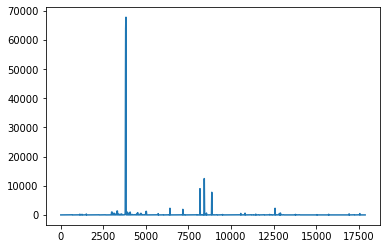

In [161]:
plt.plot(y_case)

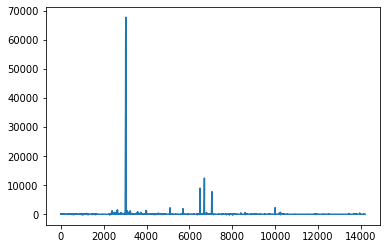

In [163]:
plt.plot(y_train_pred)          ################这不拟合的挺好的

In [164]:
mean_squared_error(y_case, y_train_pred)

518.2672454089136

In [166]:
xgb_pred_case = reg.predict(data_test_clean)

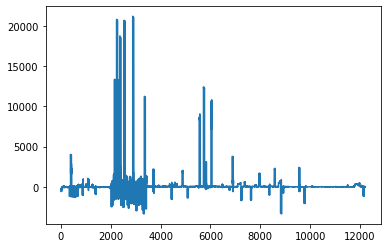

In [168]:
plt.plot(xgb_pred_case)        ###############这个负数是啥啊

In [171]:
################建模死亡人数

In [172]:
reg.fit(x, y_fatal)

[22:18:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [173]:
print(mean_squared_error(y_fatal, reg.predict(x)))

0.3201055137748399


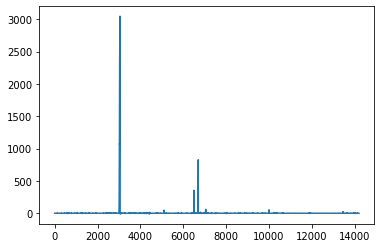

In [174]:
plt.plot(reg.predict(x))

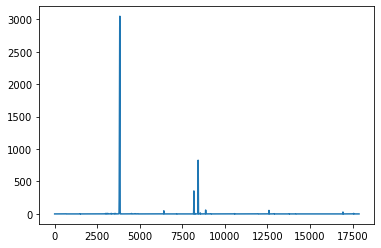

In [175]:
plt.plot(y_fatal)

In [176]:
xgb_pred_fatal = reg.predict(data_test_clean)

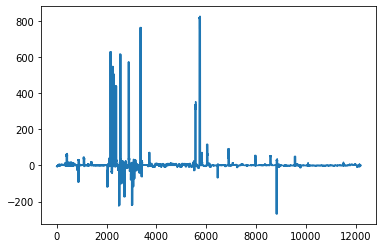

In [177]:
plt.plot(xgb_pred_fatal)

In [181]:
#################################submit_kaggle这是提交文件
######################################提交模块

In [182]:
# submission = pd.read_csv(submit_kaggle)
# submission['ConfirmedCases'] = xgb_pred_case
# submission['Fatalities'] = xgb_pred_fatal
# submission.to_csv('submission.csv', index = False)